In [ ]:
'''
This has been recreated from the following medium link.

https://medium.com/@curiousily/tensorflow-for-hackers-part-ii-building-simple-neural-network-2d6779d2f91b

The dataset used is available on Kaggle

'''

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

%matplotlib inline

In [7]:
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

In [17]:
math_df=pd.read_csv("data/student-mat.csv",sep=",")
port_df=pd.read_csv("data/student-por.csv",sep=",")

In [18]:
port_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [35]:
math_df["course"]="math"
port_df["course"]="portuguese"

In [36]:
merged_df=math_df.append(port_df)
merged_df.shape

(1044, 34)

In [37]:
merge_vector=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]

duplicated_mask=merged_df.duplicated(keep=False,subset=merge_vector)
duplicated_df = merged_df[duplicated_mask]
unique_df = merged_df[~duplicated_mask]
both_courses_mask = duplicated_df.duplicated(subset=merge_vector)
both_courses_df = duplicated_df[~both_courses_mask].copy()
both_courses_df["course"] = "both"
students_df = unique_df.append(both_courses_df)

In [38]:
students_df = students_df.sample(frac=1)
students_df['alcohol'] = (students_df.Walc * 2 + students_df.Dalc * 5) / 7
students_df['alcohol'] = students_df.alcohol.map(lambda x: ceil(x))
students_df['drinker'] = students_df.alcohol.map(lambda x: "yes" if x > 2 else "no")

In [52]:
students_df['school'].head()

315    GP
425    MS
239    GP
491    MS
292    GP
Name: school, dtype: object

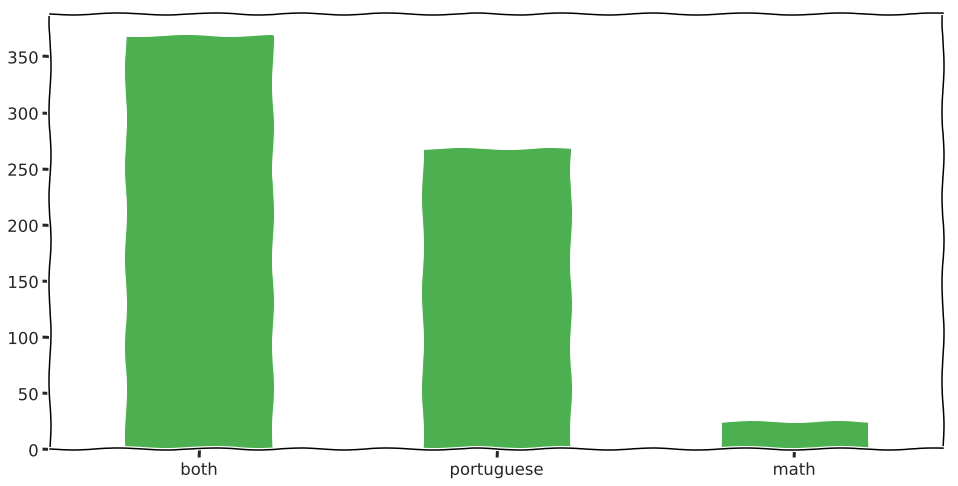

In [41]:
students_df.course.value_counts().plot(kind="bar",rot=0)

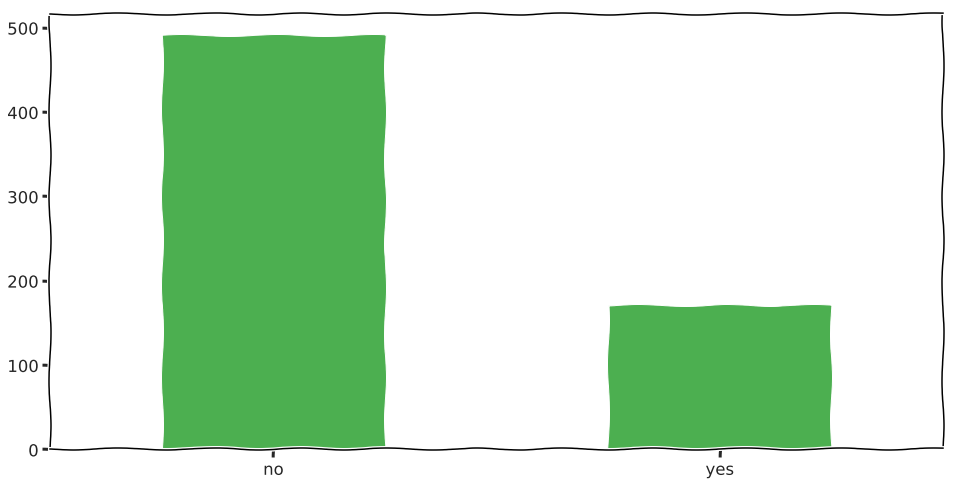

In [34]:
students_df.drinker.value_counts().plot(kind="bar", rot=0);

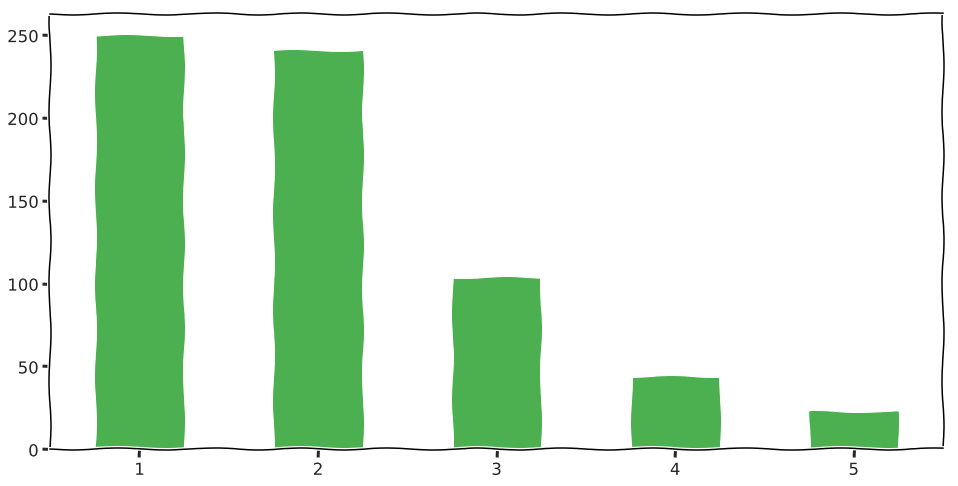

In [42]:
students_df.alcohol.value_counts().plot(kind="bar", rot=0);

/home/interstellar/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


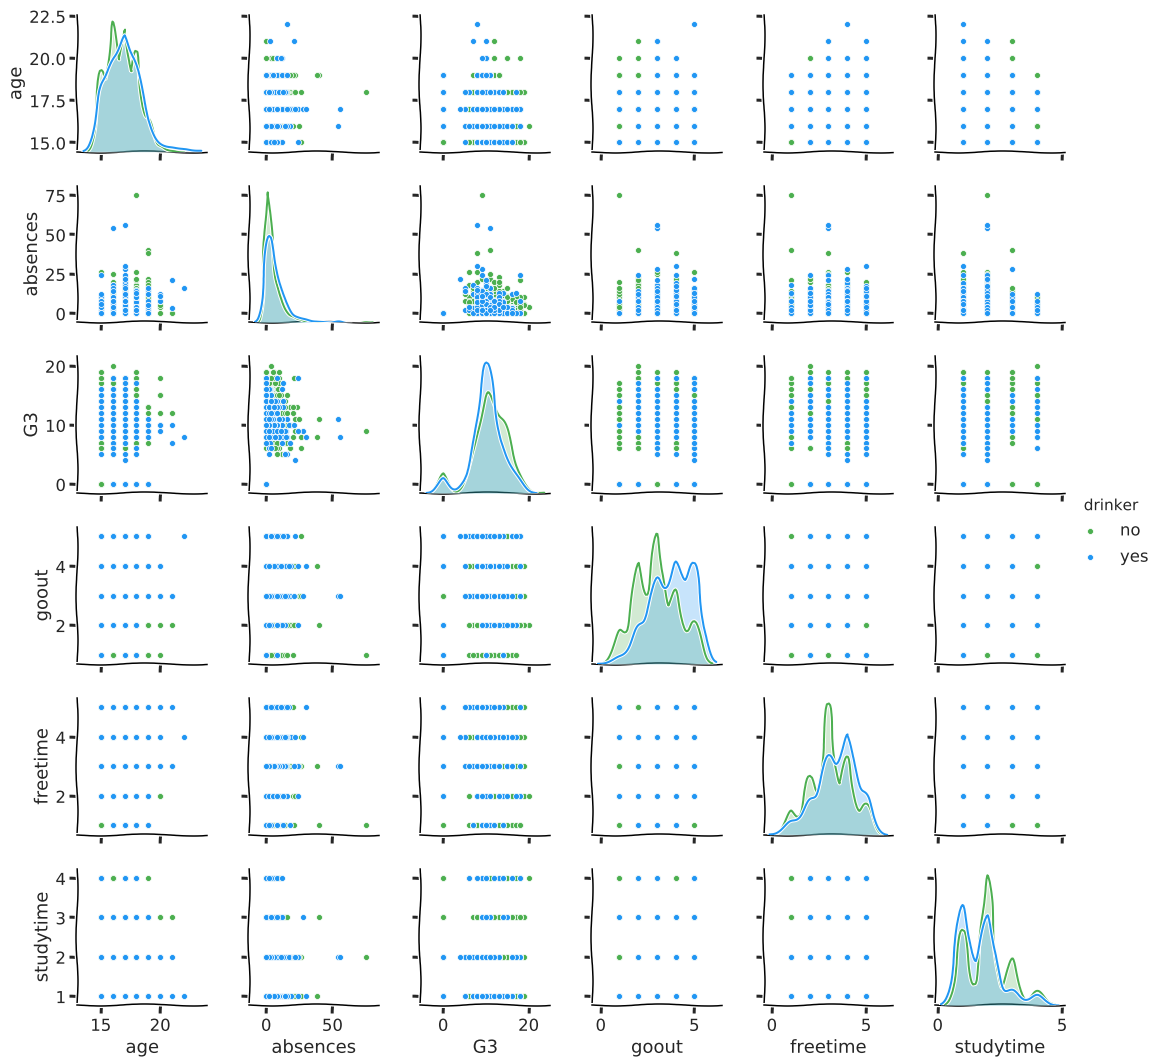

In [43]:
sns.pairplot(students_df[['age','absences','G3','goout','freetime','studytime','drinker']],hue='drinker')

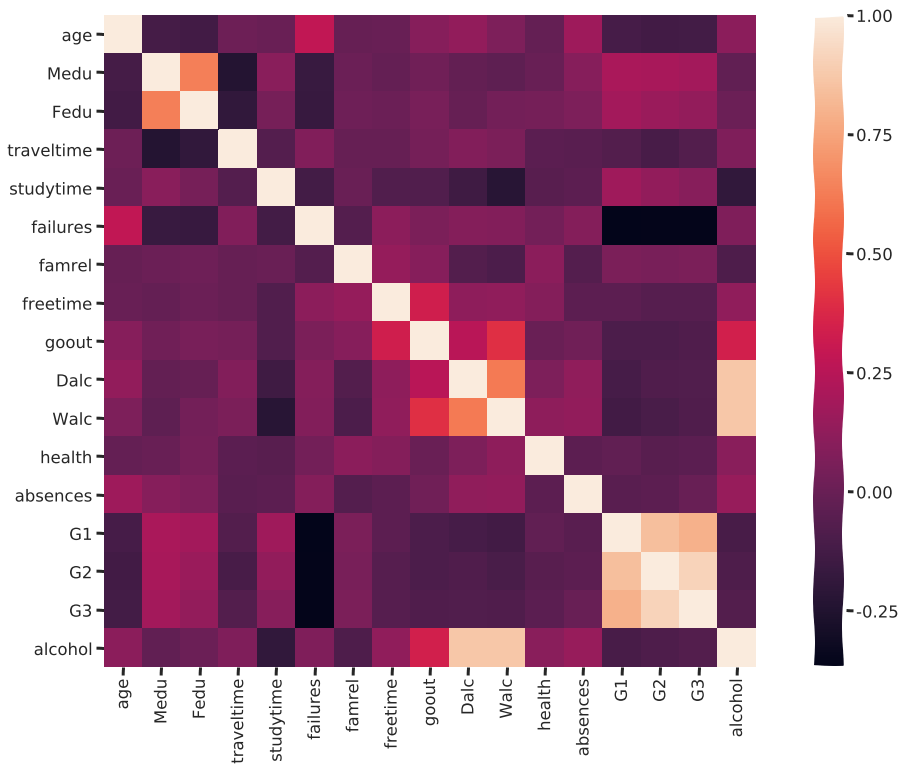

In [44]:
corr_mat=students_df.corr()
fig,ax=plt.subplots(figsize=(20,12))
sns.heatmap(corr_mat,vmax=1.0,square=True,ax=ax)

In [45]:
def encode(series):
    return pd.get_dummies(series.astype(str))

In [53]:
train_x=pd.get_dummies(students_df.school)
train_x['age']=students_df.age
train_x['absences']=students_df.absences
train_x['g1']=students_df.G1
train_x['g2']=students_df.G2
train_x['g3']=students_df.G3
train_x=pd.concat([train_x,encode(students_df.sex),encode(students_df.Pstatus), 
                     encode(students_df.Medu), encode(students_df.Fedu),
                     encode(students_df.guardian), encode(students_df.studytime),
                     encode(students_df.failures), encode(students_df.activities),
                     encode(students_df.higher), encode(students_df.romantic),
                     encode(students_df.reason), encode(students_df.paid),
                     encode(students_df.goout), encode(students_df.health),
                     encode(students_df.famsize), encode(students_df.course)
                    ], axis=1)
train_y=encode(students_df.drinker)

In [71]:
train_x.head()

,GP,MS,age,absences,g1,g2,g3,F,M,A,...,1,2,3,4,5,GT3,LE3,both,math,portuguese
315,1,0,19,40,13,11,11,1,0,0,...,0,0,1,0,0,1,0,0,1,0
425,0,1,15,6,10,10,10,1,0,0,...,0,1,0,0,0,1,0,0,0,1
239,1,0,18,0,7,7,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
491,0,1,19,12,7,8,9,1,0,0,...,1,0,0,0,0,1,0,0,0,1
292,1,0,17,2,11,12,14,1,0,0,...,0,0,0,0,1,1,0,0,0,1


In [58]:
train_size=0.9
train_cnt=floor(train_x.shape[0]*train_size)
x_train=train_x.iloc[0:train_cnt].values
y_train=train_y.iloc[0:train_cnt].values
x_test=train_x.iloc[train_cnt:].values
y_test=train_y.iloc[train_cnt:].values

In [59]:
train_cnt

595

In [70]:
x_train

array([[ 1,  0, 19, ...,  0,  1,  0],
       [ 0,  1, 15, ...,  0,  0,  1],
       [ 1,  0, 18, ...,  1,  0,  0],
       ...,
       [ 1,  0, 17, ...,  0,  0,  1],
       [ 1,  0, 15, ...,  1,  0,  0],
       [ 1,  0, 17, ...,  0,  0,  1]])

In [72]:
def multilayer_perceptron(x,weights,biases,keep_prob):
    layer_1=tf.add(tf.matmul(x,weights['h1']),biases['b1'])
    layer_1=tf.nn.relu(layer_1)
    layer_1=tf.nn.dropout(layer_1,keep_prob)
    out_layer=tf.matmul(layer_1,weights['out'])+biases['out']
    return out_layer

In [78]:
n_hidden_1=38
n_input=train_x.shape[1] #59
n_classes=train_y.shape[1] #2

In [75]:
weights={
    'h1':tf.Variable(tf.random_normal([n_input,n_hidden_1])),
    'out':tf.Variable(tf.random_normal([n_hidden_1,n_classes]))
}
biases={
    'b1':tf.Variable(tf.random_normal([n_hidden_1])),
    'out':tf.Variable(tf.random_normal([n_classes]))
}

keep_prob=tf.placeholder("float")

In [105]:
training_epochs=5000
display_step=1000
batch_size=32

x=tf.placeholder("float", [None,n_input])
y=tf.placeholder("float", [None,n_classes])

In [106]:
predictions=multilayer_perceptron(x,weights,biases,keep_prob)

In [109]:
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))

In [108]:
optimizer=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

In [110]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(x_train) / batch_size)
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                keep_prob: 0.8
                            })
            avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))

Epoch: 0001 cost= 35.468372027
Epoch: 1001 cost= 1.249193721
Epoch: 2001 cost= 0.353421847
Epoch: 3001 cost= 0.250247287
Epoch: 4001 cost= 0.239649326
Optimization Finished!
Accuracy: 0.74626863
